# Tugas Besar IF3270 Pembelajaran Mesin
### Kelompok 26

Anggota:
- 13521074 Eugene Yap Jin Quan
- 13521137 Michael Utama
- 13521138 Johann Christian Kandani
- 13521173 Dewana Gustavus Haraka Otang

## Imports

In [243]:
import numpy as np
import json
import viznet
import pickle
import matplotlib.pyplot as plt
from types import SimpleNamespace

## Input Data Class

In [244]:
class Layer:
    number_of_neurons: int
    activation_function: str

class Model:
    input_size: int
    layers: list[Layer]

class Case:
    model: Model
    input: list[list[int]]
    weights: list[list[list[int]]]

class Expect:
    output: list[list[int]]
    max_sse: int

class InputData:
    case: Case
    expect: Expect

# Fungsi Individu

### Read json👑

In [245]:
def read_json(filename: str) -> InputData:
    data: InputData | None = None

    with open(filename) as file:
        data = json.loads(file.read(), object_hook=lambda d: SimpleNamespace(**d))

    if data is None:
        raise FileNotFoundError
    
    return data

### Activation function

In [246]:
def _Linear(net: float) -> float:
    return net

def _ReLU(net: float) -> float:
    return max(0., net)

def _Sigmoid(net: float) -> float:
    denominator = (1 + np.exp(-net))
    value = 1 / denominator
    return value

def Softmax(net: np.ndarray) -> np.ndarray:
    exp_net = np.exp(net)
    print(exp_net)
    denominator = np.sum(exp_net)
    values = np.divide(exp_net, denominator)
    return values

Linear = np.vectorize(_Linear)
ReLU = np.vectorize(_ReLU)
Sigmoid = np.vectorize(_Sigmoid)

### Hitung / Feed Forward

In [247]:
# input         : 1d array
# weight        : list of 2d array
# activation    : 1d array



class NeuralNetwork:
    def __init__(self, weights: list[np.ndarray], activation_functions: list[str]):
        self.weights = weights
        self.activation_functions = activation_functions

    def ffnn(self, input: np.ndarray) -> np.ndarray:
        next = input
        for weight, activation in zip(self.weights, self.activation_functions):
            current = np.insert(next, 0, 1., axis=0)
            next = weight.transpose().dot(current)
            match activation:
                case "linear":
                    next = Linear(next)
                case "relu":
                    next = ReLU(next)
                case "sigmoid":
                    next = Sigmoid(next)
                case "softmax":
                    next = Softmax(next)

        return next

# Fungsi Integrasi

### Tampilkan model

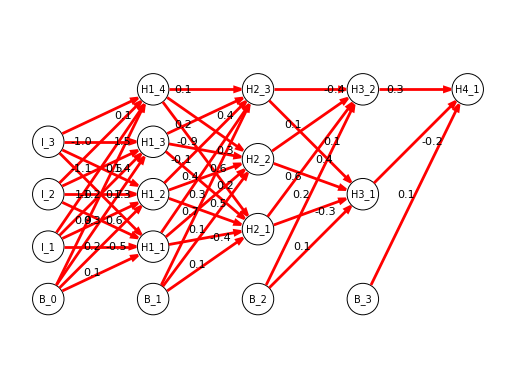

In [248]:
def plt_show():
    plt.axis('off')
    plt.axis('equal')
    plt.show()

def draw_graph(case: Case):
    # Viznet
    grid = viznet.Grid((2.0, 1.0))
    brush = viznet.NodeBrush('basic')
    edge_brush = viznet.EdgeBrush('->', lw=2, color='r')
    NODE_FONT_SIZE = 7
    EDGE_FONT_SIZE = 8
    EDGE_NODE_RATIO = 3

    layers_nodes: list[list[viznet.Node | None]] = [[] for _ in range(len(case.model.layers) + 1)]

    # Bias nodes
    for i in range(len(layers_nodes) - 1):
        node = brush >> grid[i, 0]
        node.text(f"B_{i}", fontsize=NODE_FONT_SIZE)
        layers_nodes[i].append(node)
    layers_nodes[-1].append(None)
    
    # Input layer
    input_nodes: list[viznet.Node | None] = layers_nodes[0]
    for i in range(case.model.input_size):
        node = brush >> grid[0, i+1]
        node.text(f"I_{i+1}", fontsize=NODE_FONT_SIZE)
        input_nodes.append(node)

    max_layer_num_of_neuron = 0
    for layer in case.model.layers:
        max_layer_num_of_neuron = layer.number_of_neurons if (layer.number_of_neurons > max_layer_num_of_neuron) else max_layer_num_of_neuron
    # Hidden layers
    for i, layer in enumerate(case.model.layers):
        y_ratio = max_layer_num_of_neuron/layer.number_of_neurons
        for j in range(layer.number_of_neurons):
            node = brush >> grid[i+1, (j+1)*y_ratio]
            node.text(f"H{i+1}_{j+1}", fontsize=NODE_FONT_SIZE)
            layers_nodes[i+1].append(node)
            
    # Connecting edges
    for i, layer_weights in enumerate(case.weights):
        for j, current_node in enumerate(layers_nodes[i]):
            offset_ratio = 1 / (EDGE_NODE_RATIO * len(layers_nodes[i]))
            for k, next_node in enumerate(layers_nodes[i + 1][1:]):
                edge = edge_brush >> (current_node, next_node)
                position = 'right' if j % 2 else 'left'
                edge.text(f"{layer_weights[j][k]}", position, fontsize=EDGE_FONT_SIZE, text_offset=j*offset_ratio)

    # Draw
    plt_show()

draw_graph(read_json('tc/multilayer.json').case)

### Proses 1 instance

In [249]:
def process(filename: str) -> tuple[np.ndarray, float]:
    data: InputData = read_json(filename)
    input = np.array(data.case.input[0])
    weights = [np.array(x) for x in data.case.weights]
    activations = [x.activation_function for x in data.case.model.layers]

    model = NeuralNetwork(weights, activations)

    res = model.ffnn(input)

    actual = np.array(data.expect.output)
    max_sse = data.expect.max_sse

    sse = np.sum(np.square(actual - res))

    if sse > max_sse:
        print(f"SSE({sse}) MORE THAN MAXIMUM TOLERATED SSE({max_sse})")

    return res, sse

In [250]:
print(process('tc/multilayer.json'))
print(process('tc/relu.json'))
print(process('tc/relu2.json'))
print(process('tc/softmax.json'))
print(process('tc/multilayer_softmax.json'))

(array([0.4846748]), 3.1555534707211278e-18)
(array([0.05, 1.1 , 0.  ]), 4.8148248609680896e-33)
(array([0.31 , 0.   , 0.375]), 2.465190328815662e-32)
[20.53231528  5.68596012  0.64274964]
(array([0.76439061, 0.21168068, 0.02392871]), 1.2639167722890322e-17)
[11.83853632  4.97208863]
(array([0.7042294, 0.2957706]), 1.942281739821482e-19)


### Proses batch

In [251]:
def processBatch(filename: str) -> tuple[list[np.ndarray], list[float]]:
    data: InputData = read_json(filename)
    weights = [np.array(x) for x in data.case.weights]
    activations = [x.activation_function for x in data.case.model.layers]
    max_sse = data.expect.max_sse

    ans = []
    sse_list = []

    model = NeuralNetwork(weights, activations)

    for inputarr, outputarr in zip(data.case.input, data.expect.output):
        input = np.array(inputarr)
        ans += [model.ffnn(input)]

        output = np.array(outputarr)
        sse = np.sum(np.square(output - ans[-1]))
        sse_list += [sse]

        if sse > max_sse:
            print(f"SSE({sse}) MORE THAN MAXIMUM TOLERATED SSE({max_sse})")
    

    return ans, sse_list

In [252]:
processBatch('tc/linear.json')

([array([-11.]),
  array([-8.]),
  array([-5.]),
  array([-2.]),
  array([1.]),
  array([4.]),
  array([7.]),
  array([10.]),
  array([13.]),
  array([16.])],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [253]:

processBatch('tc/sigmoid.json')

([array([0.41197346, 0.8314294 , 0.53018536, 0.31607396]),
  array([0.78266141, 0.80843631, 0.55350518, 0.64278501]),
  array([0.58987524, 0.82160954, 0.75436518, 0.34919895]),
  array([0.6722004 , 0.81660439, 0.59020258, 0.50870988]),
  array([0.47322841, 0.82808466, 0.69105452, 0.29358323])],
 [5.448747611215099e-17,
  1.8886184977662707e-17,
  3.588137593505069e-17,
  5.4935267400256686e-17,
  5.3370328317207175e-17])

Save and load model

In [254]:
data: InputData = read_json('tc/multilayer_softmax.json')
weights = [np.array(x) for x in data.case.weights]
activations = [x.activation_function for x in data.case.model.layers]

model = NeuralNetwork(weights, activations)

with open('model_save.pkl', 'wb') as file:
    pickle.dump(model, file)

In [255]:
with open('model_save.pkl', 'rb') as file:
    loaded_model: NeuralNetwork = pickle.load(file)

input = data.case.input[0]

loaded_model.ffnn(np.array(input))

[11.83853632  4.97208863]


array([0.7042294, 0.2957706])